# Neural Entropy

This notebook contains illustrative examples of the core classes and functions used in the experiments from 'Neural Entropy'. The actual experiments are automated using scripts that train the models incrementally and measure their neural entropy, KL/cross-entropy, and generate samples where applicable.

Consider a (forward) diffusion process

\begin{equation*}
    {\rm d} Y_s = b_{+}(Y_s, s) \, {\rm d} s + \sigma(s) {\rm d} \hat{B}_{s} ,
\end{equation*}

where $\hat{B}$ is the Weiner term. If a distribution $p_{\rm d}$ is subject to this process for a time $T$, it diffuses to a distribution $p_0$, say, and the total entropy produced is

\begin{equation*}
    S_{\rm tot}(T) =
    \int_{0}^{T} {\rm d} s \,  \frac{\sigma^2}{2}
    \mathbb{E}_{p}
    \left[
        \left\lVert \nabla \log p^{(t)}_{\rm eq} - \nabla \log p \right\rVert^2
    \right] ,
    \qquad
    p^{(t)}_{\rm eq} \propto \exp\left( \int^x \frac{2 b_{+}}{\sigma^2} \right) .
\end{equation*}

This is also a measure of the information that must be reinstated to convert $p_0$ back to $p_{\rm d}$. Here $p^{(t)}_{\rm eq}$ is the quasi-invariant distribution for the forward dynamics, and $p$ is the distribution that interpolates $p_{\rm d}$ and $p_0$. The 'playback' of $p$ is the optimal way of returning to $p_{\rm d}$. Under this reverse transformation, samples from $p_0$ evolve to $p_{\rm d}$ according to

\begin{equation*}
    {\rm d} X_t = -(b_{+}(X_t, T-t) - \sigma^2 \nabla \log p(X_t, t)) \, {\rm d} t + \sigma(T-t) {\rm d} B_{t} ,
\end{equation*}


where $t=T-s$. The total entropy $S_{\rm tot}(T)$ can be understood as the KL between the path measures generated by the forward and reverse SDEs, upto a boundary term. In an entropy-matching diffusion model the reverse evolution is effected by the SDE

\begin{equation*}
    {\rm d} X_t = (b_{+}(X_t, T-t) + \sigma^2 e_\theta(X_t, t)) \, {\rm d} t + \sigma(T-t) {\rm d} B_{t} .
\end{equation*}

where the neural network $e_\theta$ minimizes an equivalent of the objective

\begin{equation*}
    \mathcal{L}_{\rm EM} =
        \int_{0}^{T} {\rm d} s \,  \frac{\sigma^2}{2}
        \mathbb{E}_{p}
        \left[
            \left\lVert \nabla \log p^{(t)}_{\rm eq} - \nabla \log p + e_\theta \right\rVert^2
        \right] .
\end{equation*}

At the end of training the network has absorbed an amount of information measured by the *neural entropy*

\begin{equation*}
\boxed{
    S_{\rm NN}(T) :=
        \int_{0}^{T} {\rm d} s \,  \frac{\sigma^2}{2}
        \mathbb{E}_{p}
        \left[
            \left\lVert e_\theta \right\rVert^2
        \right] .
}
\end{equation*}



In [3]:
import jax
import jax.numpy as jnp
import flax.linen as lnn
import jax
from jax import jit, random
from typing import Sequence, Tuple
from functools import partial
import distrax
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumulative_trapezoid
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10, MNIST
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from collections import Counter
import flax.jax_utils as jax_utils
import re
import os
import unet
import gm
import model as dm
import train as tu
import util
import diffusion_util as du

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95'

rand_key = jax.random.PRNGKey(0)

## Transport experiments

We train a diffusion model with an MLP core on mixtures of Gaussians. In this case the analytic scores are known, which allows us to compare the neural results to the true answers.

Loss: 0.672474: 100%|██████████| 50/50 [02:33<00:00,  3.08s/it]  


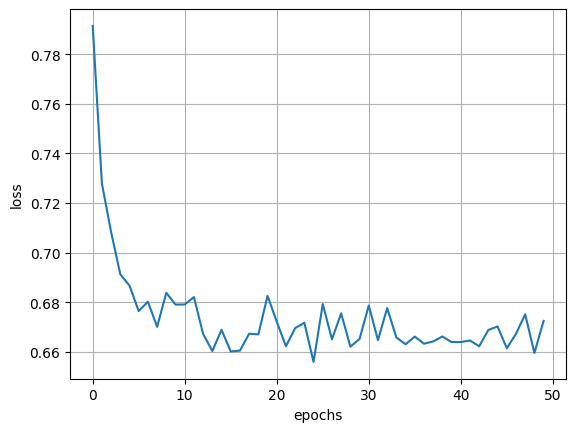

In [2]:
# Parameters
key = random.PRNGKey(32) # 22 gives a nice bimodal distribution.
D = 2  # Dimensionality
n_r = 5  # Number of components
box_size = 4
scale = 0.8

# Create the distribution p_d.
dist = gm.make_distribution_flexible(key, D, n_r, box_size, scale)

# Sample points from the distribution
key, subkey = jax.random.split(key)
samples = dist.sample(seed=subkey, sample_shape=(4096,))
samples = np.asarray(samples).copy() # We use a PyTorch data loader which does not understand JAX arrays.

dmodel = dm.DiffusionVPx(features=[512, 256, D],
                        mapping_size=256,
                        num_dimensions=D,
                        beta_min=0.1,
                        beta_max=16,
                        kappa=1, # The regular VP process
                        x_embed=True,
                        maxL_prefactor=False,
                        grf_scale_x=10.0)

# dmodel = dm.DiffusionSL(features=[512, 256, D],
#                         mapping_size=256,
#                         num_dimensions=D,
#                         Sigma_0=0.1,
#                         x_embed=True,
#                         maxL_prefactor=False,
#                         grf_scale_x=10.0)

params = dmodel.init(rand_key, samples, np.ones(samples.shape[0]))

params, losses = tu.train_diffusion_with_checkpoints(key=rand_key,
                                                    model=dmodel,
                                                    params=params,
                                                    learning_rate=0.0001,
                                                    epochs=50, # 500 is enough for SL.
                                                    train_dataset=util.DataD(samples),
                                                    batch_size=40,
                                                    num_steps=10
                                                    # checkpoint_path="./files/redux/GM_2D.msgpack"
                                                    )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

New samples can be generated using the Probability Flow (PF) ODE,

\begin{equation*}
    {\rm d} x(t) = -\left( b_{+}(x,T-t) - \frac{\sigma^2}{2} \nabla_{x} \log p(x,T-t) \right) {\rm d} t .
\end{equation*}

In the neural case we can replace approximate the score with

\begin{equation*}
    \nabla \log p \approx \nabla \log p^{(t)}_{\rm eq} + e_\theta = \frac{2 b_{+}}{\sigma^2} + e_\theta .
\end{equation*}

In [67]:
p0 = distrax.MultivariateNormalDiag(loc=jnp.zeros(2), scale_diag=jnp.ones(2) * dmodel.marginal_prob_std(1))

score_analytic = gm.score_builder(dist, dmodel)
score_neural = lambda x, s : dmodel.grad_logp_eq(x, s) + dmodel.apply(params, x, s)

gen_batch_size = 50
key = jax.random.PRNGKey(28)
samples_0 = p0.sample(seed=key, sample_shape=(gen_batch_size,))
samples_actual = dist.sample(seed=key, sample_shape=(gen_batch_size,))

samples_evol_analytic = du.transport_to_data(samples_0, dmodel, score_analytic, endtime=0.9999, num_steps=100)
samples_evol_neural = du.transport_to_data(samples_0, dmodel, score_neural, endtime=0.9999, num_steps=100)

samples_gen_analytic = samples_evol_analytic[-1]
samples_gen_neural = samples_evol_neural[-1]

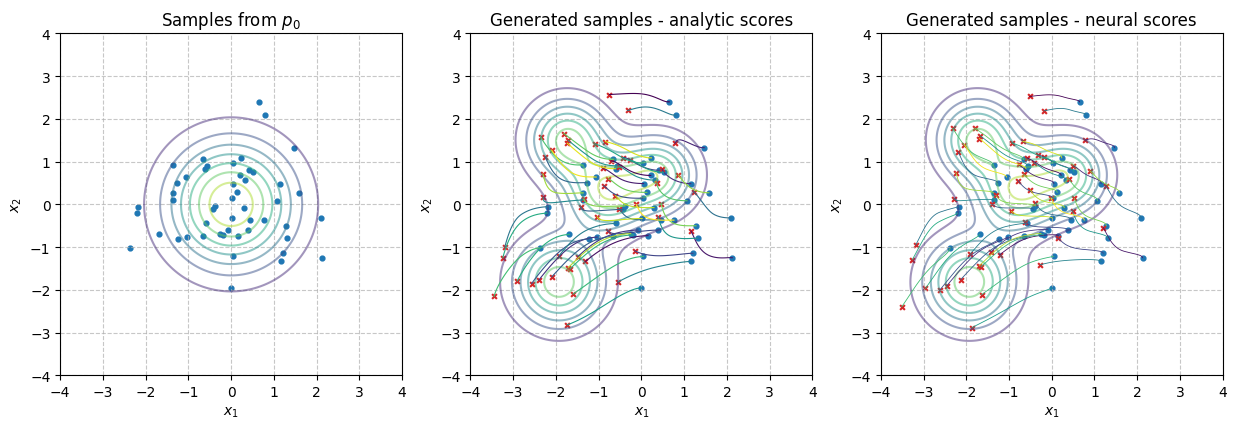

In [68]:
# Plot the solutions
_, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

# Generate unique colors using a color map
cmap = plt.get_cmap('viridis')  # Choose a colormap
colors = cmap(np.linspace(0, 1, gen_batch_size))  # Generate a unique color for each point

# Create a grid of points
view_size = 4
marker_size = 12
x1 = jnp.linspace(-view_size, view_size, 300)
x2 = jnp.linspace(-view_size, view_size, 300)
X1, X2 = jnp.meshgrid(x1, x2)
grid_points = jnp.stack([X1.ravel(), X2.ravel()], axis=-1)
probs_0 = p0.prob(grid_points).reshape(X1.shape)
probs_d = dist.prob(grid_points).reshape(X1.shape)

ax = axes[0]
ax.contour(X1, X2, probs_0, alpha=0.5)
ax.scatter(samples_0[:, 0], samples_0[:, 1], s=marker_size, color=f'C0')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim([-view_size, view_size])
ax.set_ylim([-view_size, view_size])
# ax.legend()
ax.set_title(r'Samples from $p_0$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_aspect('equal')

ax = axes[1]
ax.contour(X1, X2, probs_d, alpha=0.5)
lines = ax.plot(samples_evol_analytic[:, :, 0], samples_evol_analytic[:, :, 1], linewidth=0.8) # This plots 10 trajectories.
for line, color in zip(lines, colors):  
    line.set_color(color) 
ax.scatter(samples_0[:, 0], samples_0[:, 1], s=marker_size, color=f'C0')
ax.scatter(samples_gen_analytic[:, 0], samples_gen_analytic[:, 1], s=marker_size, color=f'C3', marker='x')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim([-view_size, view_size])
ax.set_ylim([-view_size, view_size])
# ax.legend()
ax.set_title('Generated samples - analytic scores')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_aspect('equal')

ax = axes[2]
ax.contour(X1, X2, probs_d, alpha=0.5)
lines = ax.plot(samples_evol_neural[:, :, 0], samples_evol_neural[:, :, 1], linewidth=0.6) # This plots 10 trajectories.
for line, color in zip(lines, colors):  
    line.set_color(color)
ax.scatter(samples_0[:, 0], samples_0[:, 1], s=marker_size, color=f'C0')
ax.scatter(samples_gen_neural[:, 0], samples_gen_neural[:, 1], s=marker_size, color=f'C3', marker='x')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim([-view_size, view_size])
ax.set_ylim([-view_size, view_size])
# ax.legend()
ax.set_title('Generated samples - neural scores')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_aspect('equal')

plt.show()

time step: 100%|██████████| 100/100 [00:03<00:00, 26.64it/s]


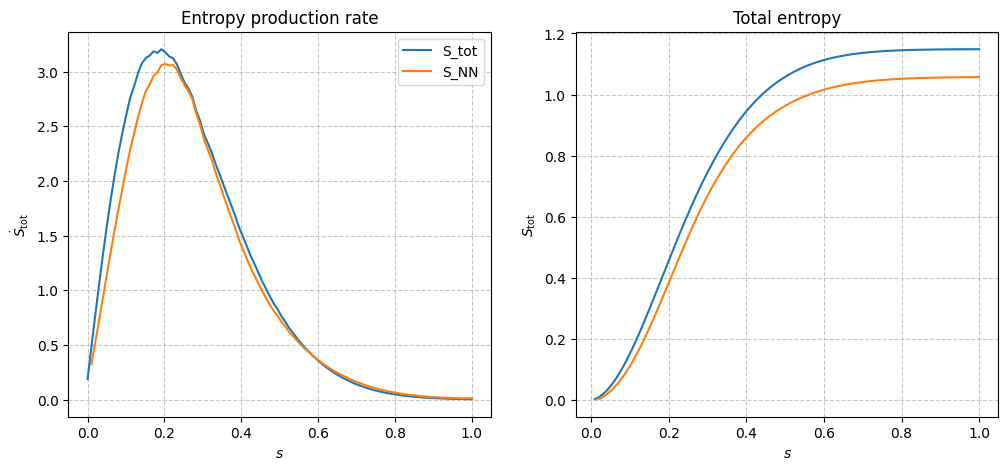

In [69]:
entropy_prod_rate_analytic = lambda x, s : 0.5 * dmodel.sigma_at(s)**2 * jnp.sum((dmodel.grad_logp_eq(x,s) - score_analytic(x,s)) ** 2, axis=-1)
entropy_prod_rate_neural = lambda x, s : 0.5 * dmodel.sigma_at(s)**2 * jnp.sum(dmodel.apply(params, x, s) ** 2, axis=-1)

batch_size = 10000
key = jax.random.PRNGKey(24)
samples_actual = dist.sample(seed=key, sample_shape=(batch_size,))

key = jax.random.PRNGKey(31)
entropy_rate_analytic, times = du.mc_entropy_rate(key, samples_actual, dmodel, entropy_prod_rate_analytic)
total_entropy_analytic = cumulative_trapezoid(entropy_rate_analytic, times)

start = 1

entropy_rate_neural, times = du.mc_entropy_rate(key, samples_actual, dmodel, entropy_prod_rate_neural)
total_entropy_neural = cumulative_trapezoid(entropy_rate_neural[start:], times[start:])

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes = axes.flatten()

ax = axes[0]
ax.plot(times, entropy_rate_analytic, label='S_tot')
ax.plot(times[start:], entropy_rate_neural[start:], label='S_NN')
ax.set_xlabel('$s$')
ax.set_ylabel('$\\dot{S}_{\\rm tot}$')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Entropy production rate')

ax = axes[1]
ax.plot(times[1:], total_entropy_analytic, label='S_tot')
ax.plot(times[start+1:], total_entropy_neural, label='S_NN')
ax.set_xlabel('$s$')
ax.set_ylabel('$S_{\\rm tot}$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Total entropy')

plt.show()

We can compute a lower bound on the log density using

\begin{equation*}
        \log \, p^{\rm em}_\theta(x,0) \geq 
        \mathbf{E}_{y_{T} \sim p(y_{T}, T|x, 0)} \left[ \log p_0(y_T) \right]
        - T \, \mathbf{E}_{s \sim \mathcal{U}(0,T)} \mathbf{E}_{y_{s} \sim p(y_{s}, s|x, 0)}
        \left[
            \frac{\sigma^2}{2} \left\| \frac{2 b_{+}}{\sigma^2} + {\bm e}_\theta \right\|^2 - (b_{+} + \sigma^2 {\bm e}_\theta) \cdot \nabla \log p(y_{s}, s|x, 0)  \right] .
\end{equation*}

The r.h.s. computed by the `DensityHelper` class and its methods.

mc iter: 100%|██████████| 10/10 [00:00<00:00, 12.56it/s]


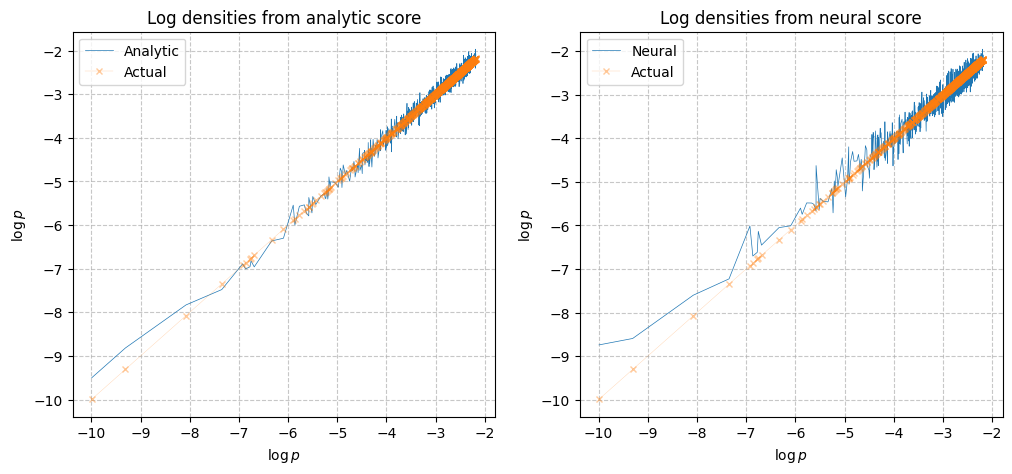

In [ ]:
# Parameters
key = jax.random.PRNGKey(32)

# Sample points from the distribution
key, subkey = jax.random.split(key)
samples = dist.sample(seed=subkey, sample_shape=(1000,))
actual_lhood = dist.log_prob(samples)

score = gm.score_builder(dist, dmodel)
mock_etheta = lambda x, s : score(x,s) - dmodel.grad_logp_eq(x,s)

etheta = lambda x, s : dmodel.apply(params, x, s)

num_steps = 1000 # Try 10000 for SL.

key, subkey = jax.random.split(key)
density_helper_EM = du.DensityHelperEM(subkey, dmodel, D, mock_etheta)
path_ent, prior_ent = density_helper_EM.mc_likelihoodOU(samples, num_steps)

# Sort the array by actual likelihood.
combined_arr = list(zip(actual_lhood, path_ent, prior_ent))
sorted_entropy = np.array(sorted(combined_arr, key=lambda x : x[0]))
sorted_lhood_analytic = np.stack([sorted_entropy[:,0], sorted_entropy[:,1]+sorted_entropy[:,2]], axis=-1)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes = axes.flatten()
ax = axes[0]
ax.plot(sorted_lhood_analytic[:,0], sorted_lhood_analytic[:,1], label='Analytic', linewidth=0.5)
ax.plot(sorted_lhood_analytic[:,0], sorted_lhood_analytic[:,0], label='Actual',
        linewidth=0.25, alpha=0.4, marker='x', markersize=4)
ax.set_title('Log densities from analytic score')
ax.set_xlabel(r'$\log p$')
ax.set_ylabel(r'$\log p$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Use the actual model to compute the neural densities.
density_helper_EM = du.DensityHelperEM(subkey, dmodel, D, etheta)
path_ent, prior_ent = density_helper_EM.mc_likelihoodOU(samples, num_steps)

# Sort the array by actual likelihood.
combined_arr = list(zip(actual_lhood, path_ent, prior_ent))
sorted_entropy = np.array(sorted(combined_arr, key=lambda x : x[0]))
sorted_lhood_neural = np.stack([sorted_entropy[:,0], sorted_entropy[:,1]+sorted_entropy[:,2]], axis=-1)

ax = axes[1]
ax.plot(sorted_lhood_neural[:,0], sorted_lhood_neural[:,1], label='Neural', linewidth=0.5)
ax.plot(sorted_lhood_neural[:,0], sorted_lhood_neural[:,0], label='Actual',
        linewidth=0.25, alpha=0.4, marker='x', markersize=4)
ax.set_title('Log densities from neural score')
ax.set_xlabel(r'$\log p$')
ax.set_ylabel(r'$\log p$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.show()

## Storage experiments

### MNIST

In [ ]:
base_dataset = MNIST(
                      './files', 
                      train=True, 
                      transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: x.permute(1, 2, 0))  # Rearrange to [28, 28, 1]
                        ]), 
                      download=True
                    )

train_dataset = util.ImageOnlyDataset(base_dataset)

train iter:   0%|          | 0/50 [00:00<?, ?it/s]

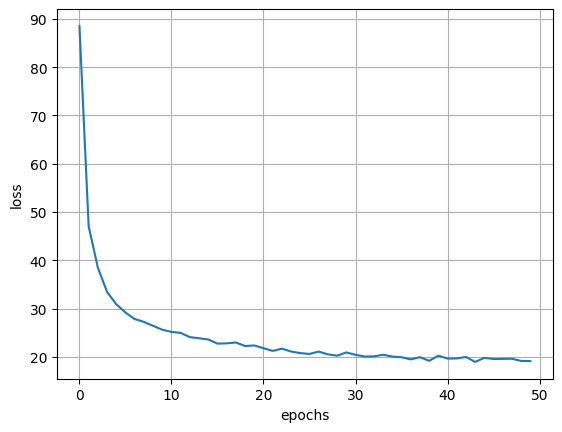

In [73]:
batch_size = 32
num_steps = 1

fake_input = jnp.ones((batch_size * num_steps, 28, 28, 1))
fake_time = jnp.ones(fake_input.shape[0])

neuralCoreUnet= unet.NeuralCoreUnet()
dmodelImg = dm.DiffusionImagesVP(neural_core=neuralCoreUnet,
                                beta_min=0.1,
                                beta_max=16,
                                kappa=1,
                                maxL_prefactor=False)
paramsImg = dmodelImg.init(rand_key, fake_input, fake_time)

paramsImg, losses = tu.train_diffusion_with_checkpoints(key=rand_key,
                                                      model=dmodelImg,
                                                      params=paramsImg,
                                                      learning_rate=0.0001,
                                                      epochs=50,
                                                      train_dataset=train_dataset,
                                                      batch_size=batch_size,
                                                      num_steps=num_steps
                                                      # checkpoint_path='./files/redux/checkpoint_EM_MNIST_Uncond.msgpack'
                                                      )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


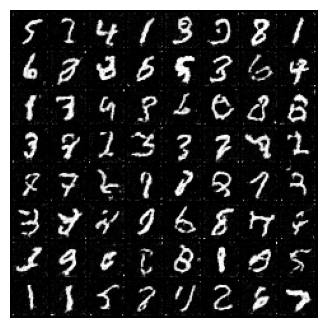

In [74]:
shape = (28, 28, 1)
p0 = distrax.MultivariateNormalDiag(loc=jnp.zeros(shape), scale_diag=jnp.ones(shape) * dmodelImg.marginal_prob_std(1))

num_samples = 64
key = jax.random.PRNGKey(24)
samples_0 = p0.sample(seed=key, sample_shape=(num_samples,))

score_neural = lambda x, s : dmodelImg.grad_logp_eq(x, s) + dmodelImg.apply(paramsImg, x, s)

samples_evolution = du.transport_to_data(samples_0, dmodelImg, score_neural, num_steps=2)
samples_gen_neural = samples_evolution[-1]

samples = jnp.transpose(samples_gen_neural.reshape((-1, 28, 28, 1)), (0, 3, 1, 2))
sample_grid = make_grid(torch.tensor(np.asarray(samples)), nrow=int(np.sqrt(num_samples)))

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

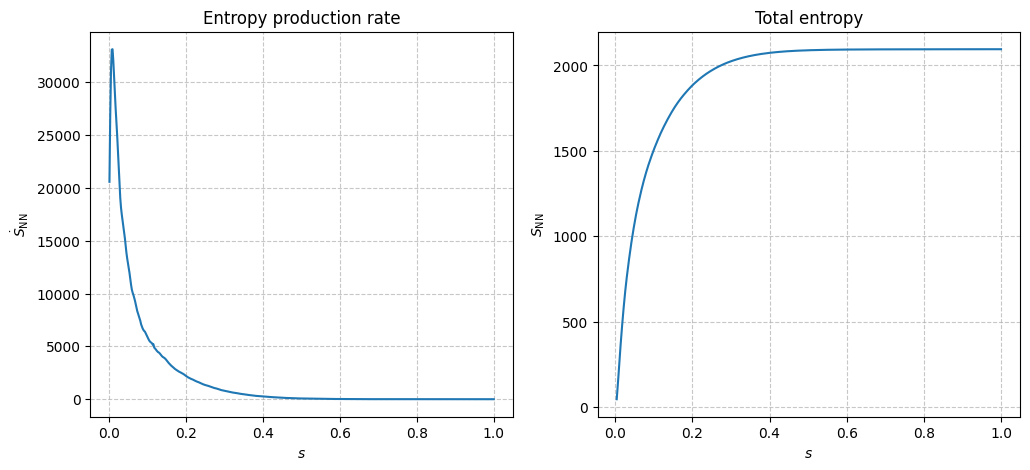

In [ ]:
def entropy_prod_rate_neural(x, s):
    return 0.5 * dmodelImg.sigma_at(s)**2 * jnp.sum(dmodelImg.apply(paramsImg, x, s) ** 2, axis=(1,2,3))

# Create the MNIST test dataset with the same transform
test_dataset = MNIST(
                    './files', 
                    train=False,  # Set to False to load the test dataset
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: x.permute(1, 2, 0))  # Rearrange to [H, W, ch]
                    ]), 
                    download=True
                )

test_batch_size = 1000

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Get a batch of test samples and their labels
test_samples, test_labels = next(iter(test_loader))
test_samples = jnp.asarray(test_samples) # JAX does not handle torch tensors.

start = 1

key = jax.random.PRNGKey(31)
entropy_rate_neural, times = du.mc_entropy_rate(key, test_samples, dmodelImg, entropy_prod_rate_neural, num_steps=500)
total_entropy_neural = cumulative_trapezoid(entropy_rate_neural[start:], times[start:])

# Plot the entropy curves.
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes = axes.flatten()

ax = axes[0]
ax.plot(times[start:], entropy_rate_neural[start:], label="Neural")
ax.set_xlabel('$s$')
ax.set_ylabel('$\\dot{S}_{\\rm NN}$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Entropy production rate')

ax = axes[1]
ax.plot(times[start+1:], total_entropy_neural, label="Neural")
ax.set_xlabel('$s$')
ax.set_ylabel('$S_{\\rm NN}$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Total entropy')

plt.show()

### CIFAR-10

In [ ]:
# Code to select only a subset of images from each class. We use this to study neural entropy growth with N.
base_dataset = CIFAR10(
                    './files', 
                    train=True, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: x.permute(1, 2, 0))  # Rearrange to [32, 32, 3]
                        ]), 
                    download=True
                    )

# Extract the unique class labels.
labels = [label for _, label in base_dataset]
classes = jnp.asarray(np.unique(labels), dtype=jnp.int32) # Unique classes in the training set
targets = np.array(base_dataset.targets)

total_samples = len(base_dataset)
label_counts = Counter(labels)
prob_c = jnp.array([label_counts[digit] / total_samples for digit in range(len(label_counts))])

# Select the first num_samples samples of the specified labels.
num_samples = 1000
limited_indices = []
for label in classes:
    label = int(label)  # Convert from jnp.int32 to plain int
    label_indices = np.where(targets == label)[0]
    selected = label_indices[:min(num_samples, len(label_indices))]
    limited_indices.append(torch.tensor(selected))

# Combine and build the subset
indices = torch.cat(limited_indices)
train_dataset = torch.utils.data.Subset(base_dataset, indices)

In [ ]:
batch_size = 40
num_steps = 1

fake_input = jnp.ones((batch_size * num_steps, 32, 32, 3))
fake_classes = jnp.ones(fake_input.shape[0], dtype=jnp.int32)
fake_time = jnp.ones(fake_input.shape[0])

neuralCoreUnetSA = unet.UNetWithSelfAttention(num_classes=len(classes),
                                         ch=256, emb_ch=1024, out_ch=3, ch_mult=[1, 1, 1], # Keep emb_ch = 4 * ch
                                         num_res_blocks=2,
                                         attn_resolutions=[8, 16], num_heads=1,
                                         dropout=0.2)
dmodelImg = dm.DiffusionImagesCondVP(neural_core=neuralCoreUnetSA,
                                    classes=classes,
                                    prior_prob=prob_c,
                                    beta_min=0.1,
                                    beta_max=16)

_ = dmodelImg.init(rand_key, fake_input, fake_classes, fake_time)

paramsImg, losses = tu.train_diffusion_with_classes(key=rand_key,
                                                        model=dmodelImg,
                                                        params=paramsImg,
                                                        learning_rate=0.0002,
                                                        epochs=10,
                                                        train_dataset=train_dataset,
                                                        batch_size=batch_size,
                                                        num_steps=num_steps,
                                                        checkpoint_path=f"./files/weights/checkpoint_{num_samples}_OG.msgpack"
                                                        )

save_path = os.path.expanduser(f'./files/weights/EntropyMatching_CIFAR10_UnetSA_AllClasses_{num_samples}_OG')
# tu.save_model_params(paramsImg, save_path)

# paramsImg = tu.load_model_params(save_path)

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

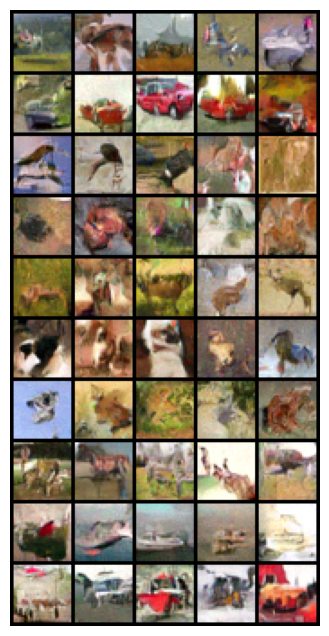

In [ ]:
c = jnp.arange(10) # Generate one image per class
num_samples_per_c = 5
sample_batch_size = len(c) * num_samples_per_c
sample_shape = (32, 32, 3)
p0 = distrax.MultivariateNormalDiag(loc=jnp.zeros(sample_shape), scale_diag=jnp.ones(sample_shape) * dmodelImg.marginal_prob_std(1))
key = jax.random.PRNGKey(27) # Change seed value to get different images.
samples_0 = p0.sample(seed=key, sample_shape=(sample_batch_size,))

class_labels = jnp.tile(c[:, jnp.newaxis], (1, num_samples_per_c)).reshape(-1)
score_neural = lambda x, s : -x + dmodelImg.apply(paramsImg, x, class_labels, s)

samples_gen_neural = du.transport_to_data(samples_0, dmodelImg, score_neural)[-1]

samples = jnp.transpose(samples_gen_neural.reshape((-1, 32, 32, 3)), (0, 3, 1, 2))
sample_grid = make_grid(torch.tensor(np.asarray(samples)), nrow=num_samples_per_c) # Each row is a specific class.

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

Next, we compute the entropy production curves.

Files already downloaded and verified


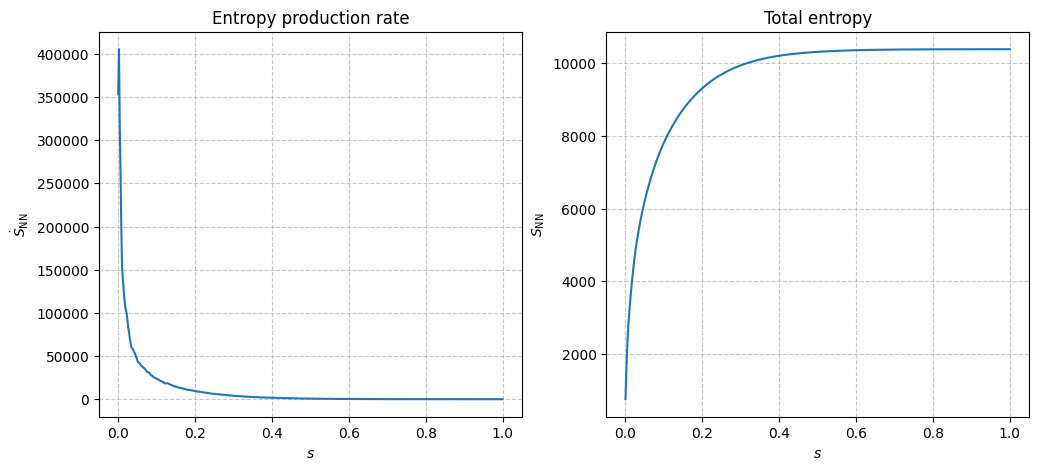

In [ ]:
def entropy_prod_rate_neural_fn(x, s, c):
    return 0.5 * dmodelImg.sigma_at(s)**2 * jnp.sum(dmodelImg.apply(paramsImg, x, c, s) ** 2, axis=(1,2,3))

# Create the CIFAR10 test dataset with the same transform
test_dataset = CIFAR10(
    './files', 
    train=False,  # Set to False to load the test dataset
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.permute(1, 2, 0))  # Rearrange to [H, W, ch]
    ]), 
    download=True
)

test_batch_size = 1000 # Not much difference when 1000 samples were used.

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Get a batch of test samples and their labels
test_samples, test_labels = next(iter(test_loader))
test_samples = jnp.asarray(test_samples) # JAX does not handle torch tensors.
test_labels = jnp.asarray(test_labels)

# # Sample visualization.
# vis_batch_size = 900
# test_samples_vis = jnp.transpose(test_samples[:vis_batch_size], (0, 3, 1, 2))
# # %matplotlib inline
# sample_grid = make_grid(torch.tensor(np.asarray(test_samples_vis)), nrow=int(np.sqrt(vis_batch_size)))

# plt.figure(figsize=(9,9))
# plt.axis('off')
# plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
# plt.show()

start = 0

key = jax.random.PRNGKey(31)
entropy_prod_rate_neural = partial(entropy_prod_rate_neural_fn, c=test_labels)
entropy_rate_neural, times = du.mc_entropy_rate(key, test_samples, dmodelImg, entropy_prod_rate_neural, num_steps=500)
total_entropy_neural = cumulative_trapezoid(entropy_rate_neural[start:], times[start:])

# Plot the entropy curves.
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes = axes.flatten()

ax = axes[0]
ax.plot(times[start:], entropy_rate_neural[start:])
ax.set_xlabel('$s$')
ax.set_ylabel('$\\dot{S}_{\\rm NN}$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Entropy production rate')

ax = axes[1]
ax.plot(times[start+1:], total_entropy_neural)
ax.set_xlabel('$s$')
ax.set_ylabel('$S_{\\rm NN}$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Total entropy')

plt.show()

# Data Analysis

We give a few examples of how the plots in the paper were generated. See `scripts/run_jobs.sh` for examples of how to run the scripts to obtain these results. The results of each experiment is stored in a separate folder whose name is a string of the experimental settings used.

In [10]:
import os
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys
from matplotlib.gridspec import GridSpec
import data_util as da

First we plot the neural entropy as it grows over the training epochs in the VPx, SL, and VP processes.

In [ ]:
# To make plots corresponding to the first script in run_job.sh.
dirs = [os.path.expanduser('./files/lab/GM_exp')]

df= da.load_gm_data(dirs)
df = df.loc[(df['D'].isin([3,6,9])) & (df['dscale'].isin([0.0]))] # For KL or S_NN vs. epochs.
df = df.sort_values(by=['seed','D', 'dscale', 'epochs'])

# Group by the columns we want to preserve
preserve_list = ['D', 'nsamples', 'batchsize', 'mLprefactor', 'epochs', 'nsteps', 'SDE', 'dscale']
grouped = df.groupby(preserve_list)

# Compute the average and standard deviation of 'KL', 'loss', and 'Stot'
avg_df = grouped[['KL', 'loss', 'Stot_neural', 'Stot_actual']].mean().reset_index()
std_df = grouped[['KL', 'loss', 'Stot_neural']].std().reset_index()

# Rename the columns to indicate they are averages or standard deviations
std_df.rename(columns={'KL': 'KL_std', 'loss': 'loss_std', 'Stot_neural': 'Stot_neural_std'}, inplace=True)

# Merge the average and std DataFrames
df_merged = pd.merge(avg_df, std_df, on=preserve_list)

# Convert the SDE field to catergorical type with custom order.
sde_custom_order = ['VPx', 'SL', 'VP']
df_merged['SDE'] = pd.Categorical(df_merged['SDE'], categories=sde_custom_order, ordered=True)

df_merged = df_merged.sort_values(by=['D', 'SDE', 'epochs'])
df_merged['SDE'] = df_merged['SDE'].astype(str)
# display(HTML(df_merged.to_html(index=False)))

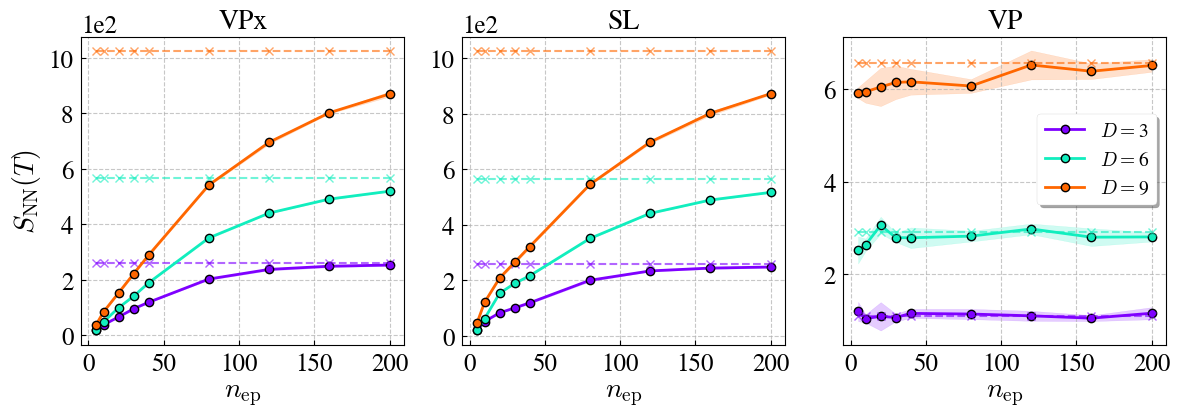

In [ ]:
def make_color(color, brightness):
    rgb_color = mcolors.to_rgb(color)
    hls_color = colorsys.rgb_to_hls(*rgb_color)
    new_rgb_color = colorsys.hls_to_rgb(hls_color[0], brightness, hls_color[2])

    return new_rgb_color
    
def texify(label):
    if label == 'nsteps':
        return r"$n_{\rm s}$"
    elif label == 'nsamples':
        return r"$N$"
    elif label == 'epochs':
        return r"$n_{\rm ep}$"
    elif label == 'Stot_neural':
        return r"$S_{\rm NN}(T)$"
    else:
        return f"${label}$"


trend = 'epochs' # The field on the x-axis
primary = 'SDE' # The field with different subplots
secondary = 'D' # The field with different colors

# # List all the field to label the plot.
labels = [secondary]
label_template = ", ".join([f"{label}={{{label}}}" for label in labels])

# Create a color map for secondary field values
unique_secondary = df[secondary].unique()
colors = plt.cm.rainbow(np.linspace(0, 0.8, len(unique_secondary)))
color_map = dict(zip(unique_secondary, colors))

df = df_merged
groupedby = df.columns.tolist()
groupedby.remove(trend)
groupedby.remove('Stot_actual')
groupedby.remove('dscale')
groupedby.remove('Stot_neural')
groupedby.remove('loss')
groupedby.remove('KL')
groupedby.remove('Stot_neural_std')
groupedby.remove('loss_std')
groupedby.remove('KL_std')
grouped = df.groupby(groupedby) # Group by remaining fields

# One plot for each primary value.
unique_primary = df[primary].unique()
yfield = 'Stot_neural'
ystd = yfield + '_std'
baseline = 'Stot_actual' # Reference value of y-field.

plt.rcdefaults()
plt.style.use('seaborn-v0_8-paper')

# For side-by-side plots.
plt.rcParams.update({
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 14
})

fig = plt.figure(figsize=(14, 4))
gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1], wspace=0.18)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
axes = np.array([ax0, ax1, ax2])

for name, group in grouped:
    # Unpack 'name' into variables dynamically
    locals().update({key: value for key, value in zip(groupedby, name)})

    primary_val = eval(primary)
    secondary_val = eval(secondary)

    # Use different color for each secondary value.
    color = color_map[secondary_val]
    new_color = make_color(color, 0.5)

    # Makes a dictionary like {'D' : D, 'nsteps' : nsteps} and uses ** to unpack and apply it to format.
    ax = axes[np.where(unique_primary == primary_val)][0]
    label_str = texify(secondary) + r"$=$" + f"{{{secondary}}}".format(**{secondary : secondary_val})
    
    ax.plot(group[trend], group[yfield], marker='o', color=new_color, label=label_str,
        markersize=6, linewidth=2, markeredgewidth=1, markeredgecolor='black')
    ax.fill_between(group[trend], group[yfield] - group[ystd], group[yfield] + group[ystd], color=new_color, alpha=0.2)
    ax.plot(group[trend], group[baseline], marker='x', color=new_color, linestyle='--', linewidth=1.5,
            markersize=6, markeredgewidth=1, alpha=0.6)
    
    # To have the ylabel displayed only for one of the side-by-side plots.
    if primary_val == 'VPx':
        ax.set_ylabel(r'$S_{\rm NN}(T)$')
    if primary_val == 'VP': # Place lower right corner of legend box at the anchor.
        ax.legend(frameon=True, fancybox=True, shadow=True, loc='center right', bbox_to_anchor=(1, 0.6))

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks([0, 50, 100, 150, 200])
    ax.set_xlabel(texify(trend))

    ax.set_title(f"{primary_val}")
    
    # Figure out the maximum ylim.
    max_idx = df[yfield].idxmax()

    if primary_val != 'VP':
        ax.ticklabel_format(axis='y', style='sci', scilimits=(2, 2))
    ax.tick_params(axis='both', which='both', direction='in')

plt.show()

Here is a plot of the neural entropy evolution at different stages of training, for the VPx process.

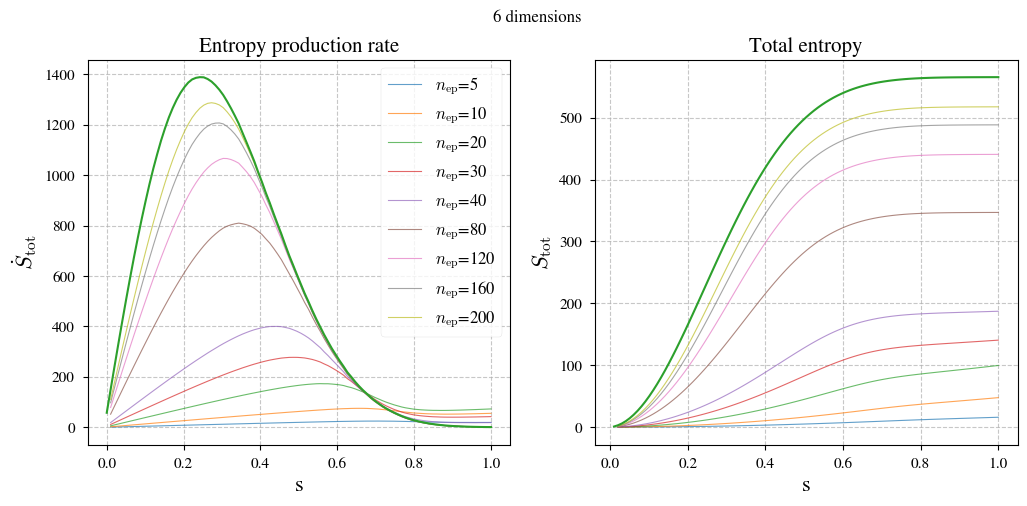

In [ ]:
def texify(label):
    if label == 'nsteps':
        return r"$n_{\rm s}$"
    elif label == 'nsamples':
        return r"$N$"
    elif label == 'epochs':
        return r"$n_{\rm ep}$"
    else:
        return f"${label}$"

def make_legends(df, keys):
    """Generate legend strings like 'epochs=20, D=3' for each row in df using the given keys."""
    return [", ".join(f"{texify(key)}={row[key]}" for key in keys) for _, row in df.iterrows()]


dirs = [os.path.expanduser('./files/lab/GM_exp')]
df = da.load_entropies(dirs)
df = df.sort_values(by=['SDE', 'nsamples', 'nsteps', 'epochs'])

D = 6
dfD = df.loc[(df['D'] == D) & (df['seed'] == 7) & (df['SDE'] == 'VPx') & (df['dscale'] == 0.0)]
# display(HTML(dfD.to_html(index=True)))

entropy_rates_analytic = dfD['er_analytic']
entropy_rates_analytic_list = np.stack(entropy_rates_analytic.tolist(), axis=-1)[:,-1]
total_entropies_analytic = dfD['te_analytic']
total_entropies_analytic_list = np.stack(total_entropies_analytic.tolist(), axis=-1)[:,-1]

entropy_rates_neural = dfD['er_neural']
entropy_rates_neural_list = np.stack(entropy_rates_neural.tolist(), axis=-1)
total_entropies_neural = dfD['te_neural']
total_entropies_neural_list = np.stack(total_entropies_neural.tolist(), axis=-1)

eps = 1e-5
times = np.linspace(eps, 1, 100)
start = 1

plt.rcdefaults()
plt.style.use('seaborn-v0_8-paper')

# For side-by-side plots.
plt.rcParams.update({
    'mathtext.fontset': 'cm',
    'font.family': 'STIXGeneral',
    'axes.labelsize': 16,
    'axes.titlesize': 15,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12
})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

ax = axes[0]
ax.plot(times[start:], entropy_rates_neural_list[start:], label="Neural", linewidth=0.8, alpha=0.7)
ax.legend(make_legends(dfD, ['epochs']))
ax.plot(times, entropy_rates_analytic_list, label="Analytic", color='C2', linewidth=1.5)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Entropy production rate')
ax.set_ylabel('$\\dot{S}_{\\rm tot}$')
ax.set_xlabel('s')

ax = axes[1]
ax.plot(times[start+1:], total_entropies_neural_list, label="Neural", linewidth=0.8, alpha=0.7)
ax.plot(times[1:], total_entropies_analytic_list, label="Analytic", color='C2', linewidth=1.5)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Total entropy')
ax.set_ylabel('${S}_{\\rm tot}$')
ax.set_xlabel('s')

fig.suptitle(f'{D} dimensions')

plt.show()